# Other dim reduction methods

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import sys
import re
import json
#os.system('pip install "librosa==0.7.1"')
#import librosa
import librosa.display
import numpy as np
import statistics
import matplotlib.pyplot as plt
from datetime import time
from datetime import datetime
import glob
from pandas.core.common import flatten
import shutil
import pickle
os.system('pip install pathlib2') # need to install
import pathlib2
import psutil
import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import umap
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [3]:
PROJECT_PATH = "/content/drive/My Drive/meerkat/" 
FIGURES = PROJECT_PATH+"figures/"
DATA = PROJECT_PATH+"data/"

os.chdir(PROJECT_PATH)

In [4]:
# Function that pads a spectrogram with zeros to a certain length
# Input: spectrogram (2D np array)
#        maximal length (Integer)
# Output: Padded spectrogram (2D np array)

def pad_spectro(spec,maxlen):
  padding = maxlen - spec.shape[1]
  z = np.zeros((spec.shape[0],padding))
  padded_spec=np.append(spec, z, axis=1)
  return padded_spec

def make_nn_stats_dict(calltypes, labels, indices):
  nn_stats_dict = {}

  for calltype in calltypes:
    call_indices = np.asarray(np.where(labels==calltype))[0]
    calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

    for i,ind in enumerate(call_indices):
      nearest_neighbors = indices[ind]
      for neighbor in nearest_neighbors:
        neighbor_label = labels[neighbor]
        calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
    nn_stats_dict[calltype] = calltype_counts 
  
  return nn_stats_dict

def get_knn(k,embedding):

  # Scale
  scaler = MinMaxScaler(feature_range=(0,10))
  scaler.fit(embedding)
  embedding = scaler.transform(embedding)
  metric_type = 'euclidean'

  # Find k nearest neighbors
  nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embedding)
  distances, indices = nbrs.kneighbors(embedding)

  # need to remove the first neighbor, because that is the datapoint itself
  indices = indices[:,1:]  
  distances = distances[:,1:]

  return indices, distances


def make_statstabs(nn_stats_dict, calltypes, labels):
  # Overall frequencies
  overall = np.zeros((len(calltypes)))
  for i,calltype in enumerate(calltypes):
    overall[i] = sum(labels==calltype)

  overall = (overall/np.sum(overall))*100


  stats_tab = np.zeros((len(calltypes),len(calltypes)))
  stats_tab_norm = np.zeros((len(calltypes),len(calltypes)))

  for i, calltype in enumerate(calltypes):
    stats = nn_stats_dict[calltype]
    stats_tab[i,:] = (np.mean(stats,axis=0)/k)*100
    stats_tab_norm[i,:] = ((np.mean(stats,axis=0)/k)*100)/overall

  stats_tab = pd.DataFrame(stats_tab)
  stats_tab_norm = pd.DataFrame(stats_tab_norm)

  stats_tab.loc[len(stats_tab)] = overall
  #stats_tab_norm.loc[len(stats_tab_norm)] = overall/overall

  stats_tab.columns = calltypes
  stats_tab.index = calltypes+['overall']

  stats_tab_norm.columns = calltypes
  stats_tab_norm.index = calltypes

  x=stats_tab_norm.replace(0, 0.0001)
  stats_tab_norm = np.log2(x)

  #stats_tab_norm = np.log2(stats_tab_norm)

  return stats_tab, stats_tab_norm

In [5]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
df = df[df.nonfocal_yn == 'n'] #  focal only
df.reset_index(inplace=True)

In [6]:
spec_df = df
dftype = 'balanced_focal'
specs = spec_df.denoised_spectrograms.values # now 2D arrays n_mels+time_frames(varying)
method = 'denoised_melspectro'

In [7]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
#flattened_specs = [pad_spectro(spec, maxlen).flatten(order='A') for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr

# Normalize
#data = StandardScaler().fit_transform(pd.DataFrame(data))

In [ ]:
data.shape

(9824, 5360)

# tSNE

In [8]:
from sklearn.manifold import TSNE

model = TSNE(n_components=3, init='pca', random_state=0, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))
embedding = model.fit_transform(data) 

# fit-sne

Need to install conda, so that I can install FFTW and fitsne. Follow this tutorial: https://rjai.me/posts/google-colab-conda/


In [ ]:
!wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh && bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local

In [ ]:
import sys
sys.path.insert(0, "/usr/local/lib/python3.6/site-packages/")

Then install fitsne, follow the description in the official documentation: https://pypi.org/project/fitsne/

In [ ]:
!conda install -yq python=3.6 cython numpy fftw

In [ ]:
!pip install fitsne

In [ ]:
#import fitsne
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
# need to do PCA initialization myself

In [ ]:
p = PCA(n_components=3, random_state=728)
p.fit(np.transpose(data))
pcs = np.transpose(p.components_)
pcs.shape

(9824, 3)

In [ ]:
# arrays need to be C_contiguous for fitSNE to work, so convert:
data = data.copy(order='C')
pcs = pcs.copy(order='C')

In [ ]:
embedding = fitsne.FItSNE(data, no_dims=3, initialization=pcs, perplexity=data.shape[0]/100, learning_rate=round(data.shape[0]/12))

# Save

In [9]:
embedding = pd.DataFrame(embedding)
embedding['index_id'] = spec_df['index_id']
#embedding['index_id'] = spec_df.index
embedding_filename = '2020-10-20'+'_'+'tsne_embedding_melspectro_denoised_balanced_focal'
print(DATA+embedding_filename)
embedding.to_pickle(DATA+embedding_filename)

/content/drive/My Drive/meerkat/data/2020-10-20_tsne_embedding_melspectro_denoised_balanced_focal


In [19]:
embedding_filename = '2020-10-20_tsne_embedding_melspectro_denoised_balanced_focal'
embedding = pd.read_pickle(DATA+embedding_filename)

In [20]:
embedding=np.asarray(embedding.drop(columns='index_id'))

In [21]:
embedding.shape

(6687, 3)

In [11]:
umap_df = spec_df

In [12]:
#t = np.linspace(0, 10, 50)
x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
#x, y, z = embedding_scaled[:,0], embedding_scaled[:,1], embedding_scaled[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = umap_df.call_lable.values
#scat_labels = umap_df.indv.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = umap_df.indv.values+" "+umap_df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

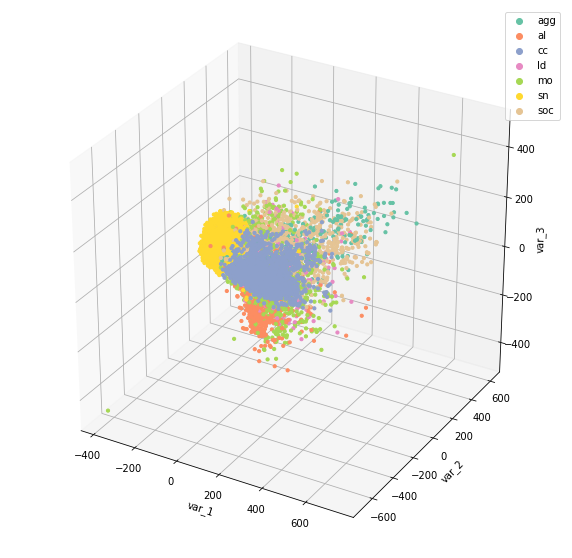

In [21]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               zs = embedding[:,2],
               #zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('var_1')
ax.set_ylabel('var_2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
ax.set_zlabel('var_3')
#ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

#plt.show()
plt.savefig(FIGURES+'2020-10-20_tsne_embedding_melspectro_denoised_balanced_focal.png')

In [15]:
from scipy.stats import gmean

In [13]:
k=5
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

indices, distances = get_knn(k,embedding)
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

In [16]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 1.9819184415024027
Log final metric (unweighted) gmean: 1.9313290006995982
Abs final metric (unweighted): 51.74


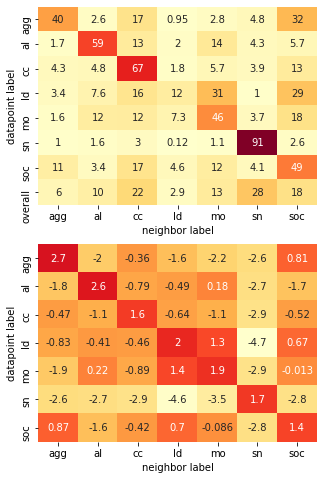

/content/drive/My Drive/meerkat/figures/2020-10-20_tsne_embedding_melspectro_denoised_balanced_focal_eval3D.png


<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

#plt.savefig(FIGURES+'2020-10-14_embedding_denoised_melspectro_balanced_eval3D.png')
plt.savefig(FIGURES+embedding_filename+'_eval3D.png')

print(FIGURES+embedding_filename+'_eval3D.png')

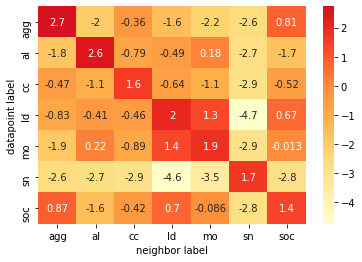

In [17]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

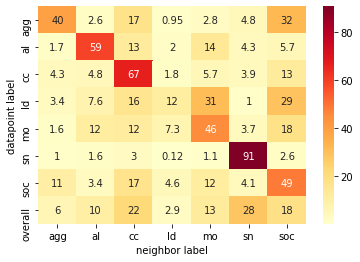

In [18]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [19]:
overall = np.asarray(stats_tab.iloc[-1:,:])[0,:]

print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.0
Log Final metric (weighted): 1.8
Abs final metric (unweighted): 51.74
Abs Final metric (weighted): 63.54


In [32]:
from scipy.stats import gmean

In [34]:
round(gmean(np.diagonal(stats_tab.iloc[:-1,])),2)

52.66

In [35]:
round(gmean([30,65,71,24,65,89,57]))

52.0

In [ ]:
help(fitsne.FItSNE)

# Convolutional autoencoder

## Load old

In [ ]:
encoded_dims = np.load(DATA+'encoded_dims_conv.npy')

In [ ]:
encoded_dims.shape

(27244, 720)

In [ ]:
df_full = pd.read_pickle(DATA+'df_denoised')

In [ ]:
df_full[df_full.index.isin(list(df['index_id']))].shape             

(9824, 34)

In [ ]:
embedding = encoded_dims[df_full.index.isin(list(df['index_id'])),:]
embedding.shape

(9824, 720)

In [ ]:
spec_df = df_full
umap_df = df_full

In [ ]:
k=5
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

indices, distances = get_knn(k,embedding)
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

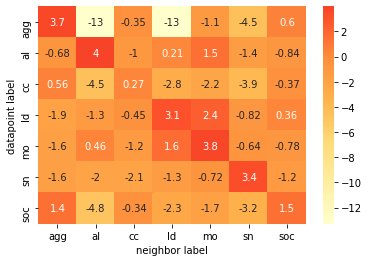

In [ ]:
# FULL
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

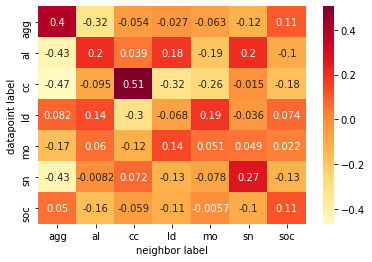

In [ ]:
#BALANCED
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

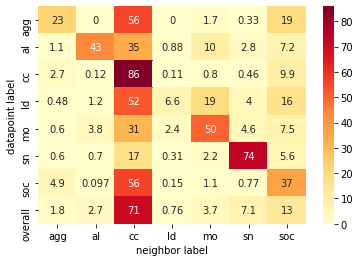

In [ ]:
# FULL
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

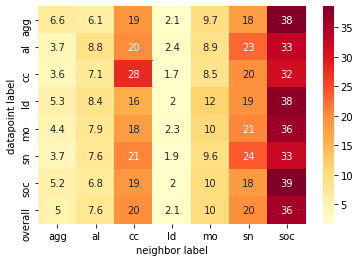

In [ ]:
# BALANCED
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [ ]:
#FULL
print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 3.0
Log Final metric (weighted): 2.2
Abs final metric (unweighted): 45.59
Abs Final metric (weighted): 54.3


In [ ]:
reducer = umap.UMAP(low_memory=True,n_components=10, min_dist=0)
embedding_UMAP = reducer.fit_transform(embedding)

In [ ]:
reducer = umap.UMAP(low_memory=True)
embedding_UMAP = reducer.fit_transform(encoded_dims)

In [ ]:
embedding_UMAP.shape

(9824, 10)

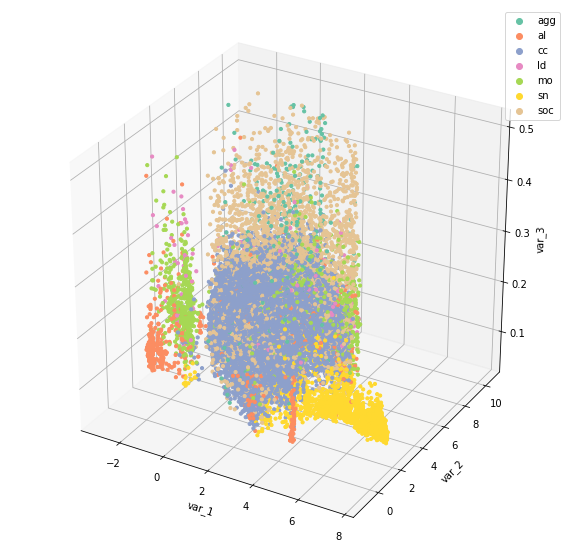

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding_UMAP[:,0],
               ys = embedding_UMAP[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               #zs = embedding_UMAP[:,2],
               zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('var_1')
ax.set_ylabel('var_2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
ax.set_zlabel('var_3')
#ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.show()

In [ ]:
#t = np.linspace(0, 10, 50)
x, y, z = embedding_UMAP[:,0], embedding_UMAP[:,1], np.asarray(umap_df.duration_s.values) #embedding[:,2]
#x, y, z = embedding_scaled[:,0], embedding_scaled[:,1], embedding_scaled[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = umap_df.call_lable.values
#scat_labels = umap_df.indv.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = umap_df.indv.values+" "+umap_df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Add duration
embedding_df = pd.DataFrame(embedding_UMAP[:,0:2])
embedding_df['duration'] = umap_df.duration_s.values

embedding_dur = np.asarray(embedding_df)

In [ ]:
embedding_dur.shape

(9824, 3)

In [ ]:
k=5

labels = umap_df.call_lable.values
calltypes = sorted(list(set(labels)))
indices, distances = get_knn(k,embedding_dur[:,0:3])
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

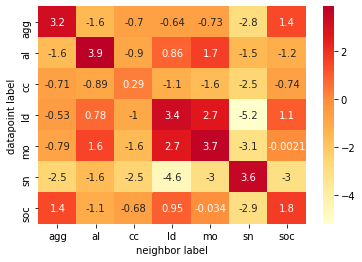

In [ ]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

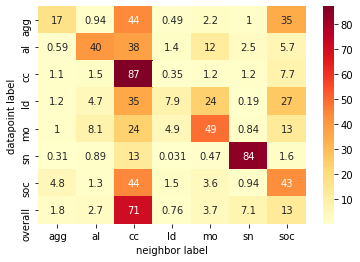

In [ ]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [ ]:
print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 3.0
Log Final metric (weighted): 2.29
Abs final metric (unweighted): 46.83
Abs Final metric (weighted): 58.25


In [ ]:
k=5

labels = umap_df.call_lable.values
calltypes = sorted(list(set(labels)))
indices, distances = get_knn(k,embedding_UMAP[:,0:3])
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

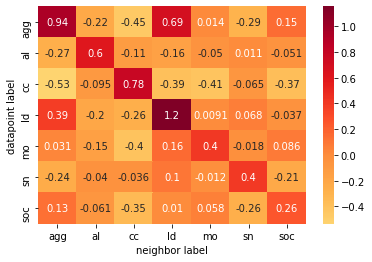

In [ ]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

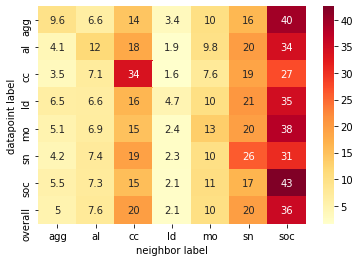

In [ ]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [ ]:
overall = np.asarray(stats_tab.iloc[-1:,:])[0,:]

print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 1.0
Log Final metric (weighted): 0.51
Abs final metric (unweighted): 20.75
Abs Final metric (weighted): 30.37


## Re-do convolution

In [33]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

In [34]:
inp_data = df.denoised_stretched_spectrograms.values
y = df.call_lable.values
dur = df.duration_s.values

In [35]:
maxlen= np.max([spec.shape[1] for spec in inp_data])
padded_specs = [pad_spectro(spec, maxlen) for spec in inp_data]

def normalize_spec(spec):
  specs_n = (spec.astype('float32')-np.min(spec)) / (np.max(spec)-np.min(spec))
  return(specs_n)

normalized_specs = [normalize_spec(spec) for spec in padded_specs]

In [36]:
data = np.stack((normalized_specs))
data.shape

(6687, 40, 142)

In [52]:
train_size = int(0.8 * data.shape[0])
test_size = data.shape[0] - train_size

#np.random.shuffle(data)
x_train, x_test = data[:train_size,:,:], data[train_size:,:,:]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), data.shape[1], data.shape[2], 1))
x_test = np.reshape(x_test, (len(x_test), data.shape[1], data.shape[2], 1))

In [62]:
input_img = Input(shape=(x_train.shape[1], x_train.shape[2], 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((4, 4), padding='same')(x) #2,2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((4, 4), padding='same')(x) #2,2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x) #2,2

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((4, 4))(x) #2,2
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x) #2,2
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x) #2,2
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(input_img)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

<tf.Tensor 'conv2d_78/Sigmoid:0' shape=(None, 40, 142, 1) dtype=float32>

In [ ]:
autoencoder.summary()

In [63]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
42/42 [==============================] - 7s 172ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 2/10
42/42 [==============================] - 8s 196ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 3/10
42/42 [==============================] - 8s 185ms/step - loss: 0.6934 - val_loss: 0.6934
Epoch 4/10
42/42 [==============================] - 7s 172ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 5/10
42/42 [==============================] - 7s 173ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 6/10
42/42 [==============================] - 7s 172ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 7/10
42/42 [==============================] - 7s 172ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/10
42/42 [==============================] - 7s 173ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/10
42/42 [==============================] - 7s 171ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/10
42/42 [==============================] - 7s 172ms/step - loss: 0.6931 - val_loss: 0.6931

In [64]:
encoder = Model(input_img, encoded)

encoded_imgs_train = encoder.predict(x_train)
encoded_imgs_test = encoder.predict(x_test)

encoded_imgs = np.concatenate((encoded_imgs_train,
                         encoded_imgs_test), axis=0)

ValueError: ignored

In [66]:
encoded_dims = encoded_imgs.reshape(6687,2*5*8)
encoded_dims.shape

(6687, 80)

In [67]:
reducer = umap.UMAP(low_memory=True, n_components=5, min_dist=0)
embedding = reducer.fit_transform(encoded_dims)

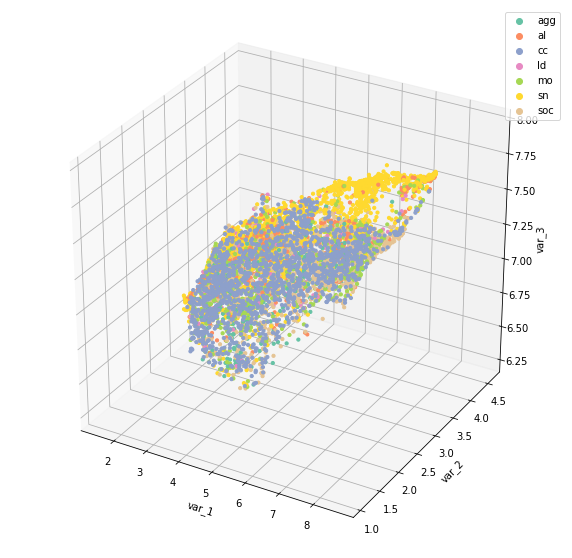

In [68]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               zs = embedding[:,2],
               #zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('var_1')
ax.set_ylabel('var_2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
ax.set_zlabel('var_3')
#ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.show()
#plt.savefig(FIGURES+'2020-10-20_conv_encoder_embedding_melspectro_denoised_balanced_focal.png')

In [ ]:
np.save(DATA+'2020-10-20_encoded_dims_conv.npy',encoded_dims)

# VGGNet

Done this previously with denoised_stretched spectrograms

In [23]:
import os
import pandas as pd
import numpy as np
import pickle
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras import models, Model
os.system('pip install annoy')
from annoy import AnnoyIndex
import random
from scipy import spatial
from scipy.spatial.distance import pdist, squareform
import PIL
from PIL import Image
import pylab
import matplotlib.pyplot as plt

In [ ]:
# First re-do stretched:

In [73]:
# Spectrogramming paramters

FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
N_MFCC = 13 # Number of cepstral coefficients
#SR = 48000
#SR = 22050 # for padded
FMAX = 4000
MAX_DURATION = 0.5

In [74]:
def generate_stretched_mel_spectrogram_NEW(data, sr, duration, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * sr) 
    hop_length = int(fft_hop * sr) 
    stretch_rate = duration/MAX_DURATION
    #stretch_rate = 1

    D = librosa.stft(y=data, # spectrogramming
                     n_fft = n_fft,
                     hop_length = hop_length,
                     window=window,
                     win_length = n_fft
                     )
    
    #D = np.abs(D)**2
    D_stretched = librosa.core.phase_vocoder(D, stretch_rate, hop_length=hop_length) # stretch spectrogram
    D_stretched = np.abs(D_stretched)**2

    spectro = librosa.feature.melspectrogram(S=D_stretched,  # mel transform
                                            sr=sr,
                                            n_mels=n_mels,
                                            fmax=4000)
        
    s = librosa.power_to_db(spectro, ref=np.max) # power to db transform

    return s


spectrograms = df.apply(lambda row: generate_stretched_mel_spectrogram_NEW(row['raw_audio'],
                                                                            row['samplerate_hz'], 
                                                                            row['duration_s'],
                                                                            N_MELS,
                                                                            WINDOW,
                                                                            FFT_WIN,
                                                                            FFT_HOP),
                        axis=1)

df['stretched_new'] = spectrograms
df['stretched_denoised_new'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['stretched_new']]

In [75]:
specs_all = df.stretched_denoised_new.values
labels_all = df.call_lable.values
IMAGES = PROJECT_PATH+'vgg_images/'

In [76]:
# Only do this once to generate images:

def make_img(spec,id):
    outname = str(id)+".jpg"
    librosa.display.specshow(spec)
    pylab.savefig(outname, bbox_inches=None, pad_inches=0)
    pylab.close()


os.chdir(IMAGES)
x = df.apply(lambda row: make_img(row['stretched_denoised_new'],row['index_id']), axis=1)

In [7]:
vgg = VGG16(weights="imagenet", input_shape=(224,224,3), include_top=True)
vgg16 = Model(vgg.input, vgg.layers[-2].output)

553467904/553467096 [==============================] - 3s 0us/step


In [8]:
image_data = []
image_filenames = os.listdir(IMAGES)
print(len(image_filenames))

6687


In [ ]:
result = np.zeros((len(image_filenames),4096))

for i,img_filename in enumerate(image_filenames): 
    print('\rProcessing file number',i, end='')
    image = load_img(IMAGES+img_filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    pred = vgg16.predict(image)
    result[i,:] = pred

np.save(DATA+'2020-10-20_result.npy', result)

Processing file number 5357

In [17]:
vgg_indices = np.asarray([int(img.split('.')[0]) for img in image_filenames])
np.save(DATA+'2020-10-20_vgg_indices.npy', vgg_indices)

## Load data

In [24]:
result = np.load(DATA+'2020-10-20_result.npy')
vgg_indices = np.load(DATA+'2020-10-20_vgg_indices.npy')

Cosine distance is recommend for the 4096-dim output

In [25]:
distmat = squareform(pdist(result, metric='cosine'))

In [26]:
reducer = umap.UMAP(low_memory=True,n_components = 5,  metric='precomputed', min_dist=0, angular_rp_forest=True, random_state=2204)
embedding = reducer.fit_transform(distmat)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



In [27]:
df = pd.read_pickle(DATA+'df_denoised_balanced') # balanced
df = df[df.nonfocal_yn == 'n'] #  focal only
df.reset_index(inplace=True)

In [31]:
call_ids=[]
for ind in vgg_indices:
    call_ids.append(df.loc[df.index_id==ind,'index_id'].values[0])
call_ids = np.asarray(call_ids)

In [32]:
# save embedding
embedding = pd.DataFrame(embedding)
embedding['index_id'] = call_ids
#embedding['index_id'] = spec_df.index
embedding_filename = '2020-10-23'+'_'+'VGG'
print(DATA+embedding_filename)
embedding.to_pickle(DATA+embedding_filename)

/content/drive/My Drive/meerkat/data/2020-10-23_VGG


In [33]:
embedding = np.asarray(embedding)[:,0:5]

In [34]:
call_labels=[]
for ind in vgg_indices:
    call_labels.append(df.loc[df.index_id==ind,'call_lable'].values[0])
call_labels = np.asarray(call_labels)

In [22]:
dur=[]
for ind in vgg_indices:
    dur.append(df.loc[df.index_id==ind,'duration_s'].values[0])

dur = np.asarray(dur)

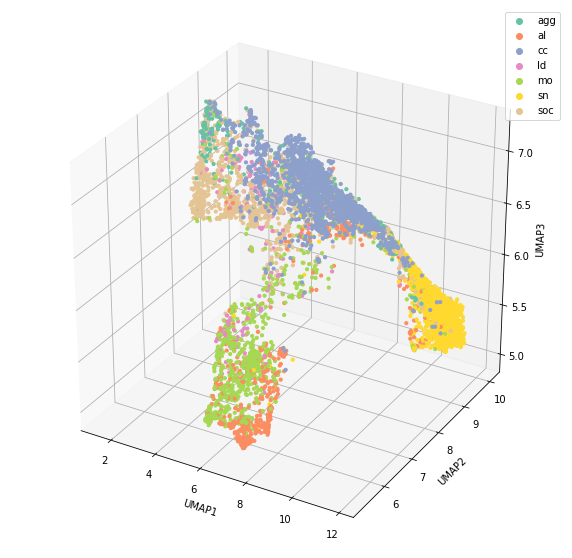

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = call_labels
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               zs = embedding[:,2],
               #zs= dur,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.savefig(FIGURES+'2020-10-23_VGGNet_denoised_melspectro_balanced_focal')

In [52]:

x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = df.call_lable.values

labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = df.indv.values+" "+df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [40]:
# Add duration
embedding_df = pd.DataFrame(embedding)
embedding_df['duration'] = df.duration_s.values

embedding_dur = np.asarray(embedding_df)

In [ ]:
k=5
labels = call_labels
calltypes = sorted(list(set(labels)))

indices, distances = get_knn(k,embedding[:,0:3])
#indices, distances = get_knn(k,embedding[:,0:3])
#indices, distances = get_knn(k,embedding_dur)
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

In [39]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.133208864270183
Log final metric (unweighted) gmean: 2.0702134586477787
Abs final metric (unweighted): 54.79


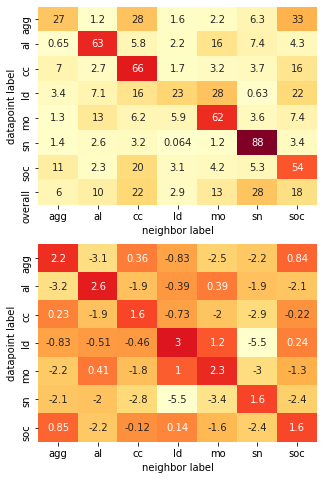

/content/drive/My Drive/meerkat/figures/2020-10-23_VGG_eval3D.png


<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(figsize=(5,8))

plt.subplot(2, 1, 1)
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
#plt.show()

# for easier interpretation: fold likelihood (x times more likely to find label in neighborhood
# than expected by chance)
#plt.subplot(1, 3, 2)
#ax=sns.heatmap(np.power(2,stats_tab_norm), center=5, annot=True, cmap='YlOrRd')
#plt.xlabel("neighbor label")
#plt.ylabel("datapoint label")
#plt.show()

plt.subplot(2, 1, 2)
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd', cbar=None)
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

#plt.savefig(FIGURES+'2020-10-14_embedding_denoised_melspectro_balanced_eval3D.png')
plt.savefig(FIGURES+'2020-10-23_VGG_eval3D.png')

print(FIGURES+'2020-10-23_VGG_eval3D.png')

In [ ]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

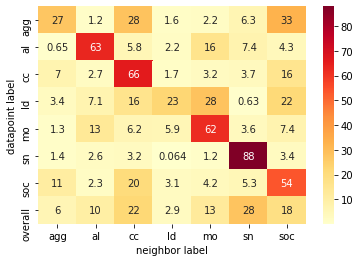

In [38]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [50]:
overall = np.asarray(stats_tab.iloc[-1:,:])[0,:]

print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 2.0
Log Final metric (weighted): 1.96
Abs final metric (unweighted): 58.81
Abs Final metric (weighted): 69.3


# PCA

In [43]:
from sklearn.decomposition import PCA

In [41]:
data.shape

(6687, 5360)

In [44]:
p = PCA(n_components=3, random_state=728)
data_z = StandardScaler().fit_transform(pd.DataFrame(data))
p.fit(np.transpose(data_z))
embedding = np.transpose(p.components_)

In [45]:
umap_df.shape

(6687, 36)

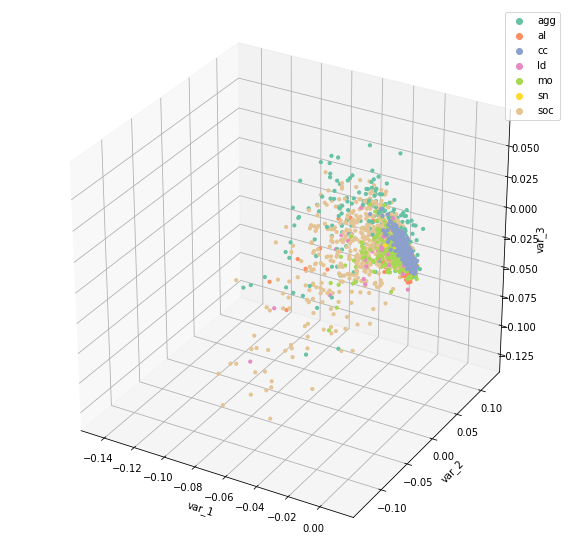

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = umap_df.call_lable.values
#scat_labels = aggl_clusterer.labels_
#scat_labels = kmeans.labels_
labeltypes = sorted(list(set(scat_labels)))

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
               xs = embedding[:,0],
               ys = embedding[:,1],
               #xs = umap_df['UMAP1'],
               #ys = umap_df['UMAP2'],
               zs = embedding[:,2],
               #zs= umap_df.duration_s.values,
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('var_1')
ax.set_ylabel('var_2')

#ax.set_xlabel('tSNE1')
#ax.set_ylabel('tSNE2')
ax.set_zlabel('var_3')
#ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
  scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

plt.savefig(FIGURES+'2020-10-23_PCA_embedding_melspectro_denoised_balanced_focal.png')

In [27]:
#t = np.linspace(0, 10, 50)
x, y, z = embedding[:,0], embedding[:,1], embedding[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]
#x, y, z = embedding_scaled[:,0], embedding_scaled[:,1], embedding_scaled[:,2] #np.asarray(umap_df.duration_s.values) #embedding[:,2]

scat_labels = umap_df.call_lable.values
#scat_labels = umap_df.indv.values
labeltypes = sorted(list(set(scat_labels)))
# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = umap_df.indv.values+" "+umap_df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

In [46]:
k=5

labels = umap_df.call_lable.values
calltypes = sorted(list(set(labels)))
indices, distances = get_knn(k,embedding[:,0:3])
nn_stats_dict = make_nn_stats_dict(calltypes, labels, indices)
stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels)

In [47]:
print("Log final metric (unweighted):",np.mean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Log final metric (unweighted) gmean:",gmean(np.diagonal(stats_tab_norm)))
#print("Log Final metric (weighted):",round(gmean(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
#print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 1.4812280137445395
Log final metric (unweighted) gmean: 1.4459363014190796
Abs final metric (unweighted): 38.2


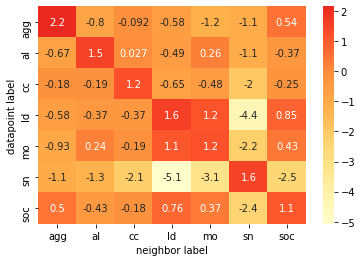

In [30]:
ax=sns.heatmap(stats_tab_norm, center=0, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()


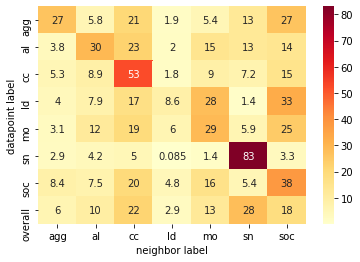

In [31]:
ax=sns.heatmap(stats_tab, annot=True, cmap='YlOrRd')
plt.xlabel("neighbor label")
plt.ylabel("datapoint label")
plt.show()

In [32]:
overall = np.asarray(stats_tab.iloc[-1:,:])[0,:]

print("Log final metric (unweighted):",round(np.mean(np.diagonal(stats_tab_norm))))
print("Log Final metric (weighted):",round(np.average(np.diagonal(stats_tab_norm), weights=overall),2))
print("Abs final metric (unweighted):",round(np.mean(np.diagonal(stats_tab.iloc[:-1,])),2))
print("Abs Final metric (weighted):",round(np.average(np.diagonal(stats_tab.iloc[:-1,]), weights=overall),2))

Log final metric (unweighted): 1.0
Log Final metric (weighted): 1.39
Abs final metric (unweighted): 38.2
Abs Final metric (weighted): 50.41
